# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [1045]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Looks we had some trouble already while importing with some features that have mixed types values

In [1046]:
# These two featutres have mixed type float and string
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [1047]:
azdias.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [1048]:
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

This shows a problem with this table where there are same values that are different because of the type either int or fload

In [1049]:
# Let's fix it straightaway
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X': np.nan})
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX':np.nan})
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)


So the values X and XX in these two tables are to be considered "unknown" and converted to null. So in our initial cleaning we will check the values of the documented features against the documentation ( the "DIAS Attributes - Values 2017.xlsx" file) and consider the ones that fall outside the reanges priveded as null.


In [1050]:
# Reading the features description excel file into a Dataframe
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', index_col=[0, 1, 2]).reset_index()
feat_info.drop('level_0', axis=1, inplace=True)
feat_info_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', index_col=[0, 1]).reset_index()
feat_info_levels.drop('level_0', axis=1, inplace=True) 

feat_info_levels.head()
feat_info[feat_info.Attribute=='CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [1051]:
# Turns out the feat_info dataset from the Excel spreadsheet has some columns that are not in the population dataset
# and vicecersa, Let's explore a bit
# These one are in the population and are described in the spreadsheet
attributes_we_have_info_about = np.intersect1d(feat_info.Attribute.unique(), np.array(azdias.columns))
# These one are in the population and are NOT described in the spreadsheet
attributes_we_dont_have_info = np.setdiff1d(np.array(azdias.columns), feat_info.Attribute.unique())
# These one are in the spreadsheet and are NOT in the population so we just ignore them for now
attributes_we_dont_care = np.setdiff1d(feat_info.Attribute.unique(), np.array(azdias.columns))

len(attributes_we_have_info_about), len(attributes_we_dont_have_info), len(attributes_we_dont_care)

(270, 96, 42)

In [1052]:
# we can build a dataframe with atributes and type plus description of unknown values 
unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known', 'numeric value (typically coded from 1-10)',
                 'numeric value (typically coded from 1-3)', 'no transaction known']
azdias_info =  feat_info[(feat_info.Attribute.isin(attributes_we_have_info_about)) & (feat_info.Meaning.isin(unknown_values))]
# Add the ones who don't have unknown values

# Add columns that are in the excel spreadhseet but don't have a "unkmown value"
for feat in np.setdiff1d(feat_info.Attribute[attributes_we_have_info_about].index, dias_info.Attribute):
    azdias_info = dias_info.append(feat_info[feat_info.Attribute == feat].iloc[0,:2])

# Finally add columns missing if the excel spreadsheet
azdias_info = pd.concat([dias_info, pd.DataFrame(np.setdiff1d(azdias.columns.values, dias_info.Attribute), columns=['Attribute'])], sort=False, axis=0)

# Adding a Type column initially setting everything to 'Ordinal' 
azdias_info['Type'] = 'Ordinal'
azdias_info.to_csv('azdias_info.csv')

In [1053]:
# Reload file after working on in in Excel
azdias_info = pd.read_csv('azdias_info_reload.csv', index_col=[0])

azdias_info.head()
#azdias_info.Type.value_counts()

,Attribute,Description,Meaning,Value,Type,Notes
0,AGER_TYP,best-ager typology,unknown,-1,Ordinal,NaN
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"-1, 0",Ordinal,NaN
11,ALTER_HH,main age within the household,unknown / no main age detectable,0,Ordinal,NaN
33,ANREDE_KZ,gender,unknown,"-1, 0",Binary,NaN
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),0,Numeric,NaN


So we will start handling the features that are documented for now and run some cleaning scripts, then we will explore the undocumented ones and decide what to do with them.

In [1054]:
# Check values for a random feature
# split a string is a string otherwise return unchanged
def split_if_string(x):
    if isinstance(x, str):
        return x.split(',')
    else:
        return x
# Change ints into floats in a list and leave anything else unchanged
def to_float(x):
    try:
        x = float(x)
    except:
        pass
    return x

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [1055]:
# Now we will look for "undocumented" null values, that are not included in the spreadsheet

attributes_to_check = np.setdiff1d(attributes_we_have_info_about, numerical_features)

# Better align values first as it is taking as different int and floats

def check_all_values(df, feat_info):
    for attribute in attributes_to_check:
        theoretical_vals = feat_info[feat_info.Attribute == attribute].Value.apply(lambda x: split_if_string(x)).values
        theoretical_vals = np.hstack(theoretical_vals)
        theoretical_vals = [to_float(x) for x in theoretical_vals]
        actual_values = df.loc[:, attribute].value_counts().index.values
        actual_values = [to_float(x) for x in actual_values]
        #diff = set(actual_values) - set(theoretical_vals)
        diff = np.setdiff1d(actual_values, theoretical_vals)
        if diff.size > 0:
            print('Attribute {} has undocumented values {}'.format(attribute, diff))

            
check_all_values(azdias, feat_info)

Attribute CAMEO_DEU_2015 has undocumented values ['XX']
Attribute KBA05_MODTEMP has undocumented values [6.]
Attribute LP_FAMILIE_FEIN has undocumented values [0.]
Attribute LP_FAMILIE_GROB has undocumented values [0.]
Attribute LP_LEBENSPHASE_FEIN has undocumented values [0.]
Attribute LP_LEBENSPHASE_GROB has undocumented values [0.]
Attribute ORTSGR_KLS9 has undocumented values [0.]


So here we have:

CAMEO_DEU_2015: most common building-type within the cell => XX is a null

KBA05_MODTEMP: development of the most common car segment in the neighbourhood: we keep 6.0 although it's not documented

LP_FAMILIE_FEIN: familytyp fine: 0 is a null, must be between 1 to 11

LP_FAMILIE_GROB familytyp rough, must be 1 to 11, so 0 is a null

LP_LEBENSPHASE_FEIN: lifestage fine, must be 1 to 40, so 0 is a null

LP_LEBENSPHASE_GROB: lifestage rough, must be 1 to 12, so 0 is  a null

ORTSGR_KLS9: size of the community, 1 to 9, so 0 is a null


In [1056]:
# we can fix those above
def fix_undocumented_nulls(df):
    dxx = {'XX':np.nan}
    d0 = {0:np.nan}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(dxx)
    df['LP_FAMILIE_FEIN'] = df['LP_FAMILIE_FEIN'].replace(d0)
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].replace(d0)
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace(d0)
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(d0)
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace(d0)
    return df
azdias =  fix_undocumented_nulls(azdias)

,Attribute,Description,Meaning,Value,Type,Notes
39,ANZ_TITEL,number of professional title holder in household,numeric value (typically coded from 1-10),NaN,Numeric,NaN


Now we will use the dataframe we built with the nformation of whoch values cam be considered null to replace the unlknown values with null.
We leave the features that have a value equal to zero with Meaning "no transaction known"as they represent transactional activity over a period, so we interpret is as "zero transactions".


In [1057]:
# Now let's convert the other nulls
#azdias_info.head()
import progressbar

def unknown2nulls(df, df_info):
    """"""
    
    n_iters = df_info.shape[0]
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_iters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for _, info_row in df_info[df_info.Value.notnull()].iterrows():
        #print('Replacing ', info_row.Attribute)
        if isinstance(info_row.Value, str):
            d = {}
            for unknown_value in info_row.Value.split(','):
                d[float(unknown_value)] = np.nan
            df[info_row.Attribute] = df[info_row.Attribute].replace(d)
        else:
            d = {info_row.Value : np.nan}
            df[info_row.Attribute] = df[info_row.Attribute].replace(d)
        cnter+=1 
        bar.update(cnter)
    
    bar.finish()            
    return df

azdias = unknown2nulls(azdias, azdias_info)

[========================================================================] 100%


In [1058]:
# Now we can save it
azdias.to_feather('azdias_nulls.feather')

### Choosing columns to drop
We will analyze the amount of missing data and choose which columns to drop.
Additionally some columns may be dropped for tyher reasons, for example:
- if they have unique values
- if they are categorical values with too many different values, for example more than 10 categories
- when we don't have enough information to decide how to encode them
- features that are a possible source of ethical bias

In [658]:
azdias = pd.read_feather('azdias_nulls.feather', nthreads=2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


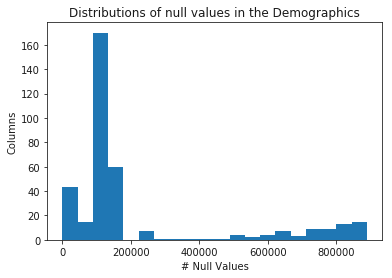

In [1059]:
# Assess missing data in columns
plt.hist(azdias.isnull().sum(), bins=20)
plt.title('Distributions of null values in the Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Columns');

In [1060]:
# Investigate patterns in the amount of missing data in each column.
columns = azdias.isnull().sum().sort_values(ascending=False)
#[(columns, nulls) for columns, nulls in columns.items() if nulls > 0]


Text(0.5,1,'Attributes with more than 30% of missing values')

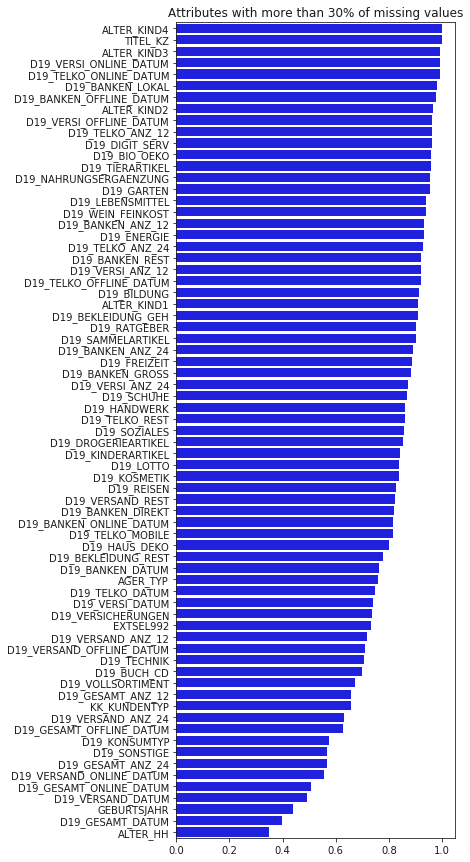

In [1061]:
percent_missing = columns/azdias.shape[0]
data = percent_missing[percent_missing > 0.3]
plt.figure(figsize=(5,15))
sns.barplot(y=data.index, x=data.values, orient='h', color='blue')
plt.title("Attributes with more than 30% of missing values")

In [1062]:
#The distribution above shows that some outlier features have more thn 250000 null values. 
# Since we will run this script on the customer data set as well, we will use a % of the whole dataset =>28%
# Considering the dataset has 891221 data points, we can select those ones candidates features to be dropped
columns_to_drop = [s for s, v in (azdias.isnull().sum() > azdias.shape[0] * 0.3).items() if v]

azdias.drop(columns_to_drop, axis=1, inplace=True)
print("Dropped {} columns.".format(len(columns_to_drop)))

Dropped 71 columns.


Column with unique values

In [1029]:
# Columns with unique values, doesn't give any information
azdias.LNR.value_counts().shape

(891221,)

In [1063]:
# So we will drop it
azdias.drop('LNR', axis=1, inplace=True)

Features that are a possible source of ethical bias

In [1064]:
# NATIONALITAET_KZ: possible source of ethical bias
azdias.drop('NATIONALITAET_KZ', axis=1, inplace=True)

In [1065]:
# ALTERSKATEGORIE_FEIN and ALTERSKATEGORIE_GROB (age through prename analysis have different number of nulls, 
# in particular ALTERSKATEGORIE_FEIN has 262947 nulls so we prefer to drop it and keep the summary information)
azdias.drop('ALTERSKATEGORIE_FEIN', axis=1, inplace=True)

Exploring Categiorical Features with Multi-values

In [1066]:
# Let's have a look at the other categorical features (the ones who are left)
categorical_features = np.intersect1d(azdias_info[azdias_info.Type=='Categorical'].Attribute.values, azdias.columns.values)
categorical_to_drop = []
for categ in categorical_features:
    num_categs = azdias[categ].value_counts().shape[0]
    if num_categs > 15:
        print("Feature {} has {} categories".format(categ, num_categs))
        categorical_to_drop.append(categ)


categorical_to_drop
# We ca drop these features abd one-hot encode the other ones    

Feature CAMEO_DEU_2015 has 44 categories
Feature D19_LETZTER_KAUF_BRANCHE has 35 categories
Feature EINGEFUEGT_AM has 5162 categories
Feature LP_LEBENSPHASE_FEIN has 40 categories
Feature VERDICHTUNGSRAUM has 46 categories


['CAMEO_DEU_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'LP_LEBENSPHASE_FEIN',
 'VERDICHTUNGSRAUM']

In [1067]:
# We will drop CAMEO_DEU_2015 (redundant), EINGEFUEGT_AM (has dates, not interesting), D19_LETZTER_KAUF_BRANCHE, VERDICHTUNGSRAUM, while it looks the other features carry important information:
# But we will keep LP_LEBENSPHASE_FEIN:  Lifestage (fine), as it has interesting information
# and CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup
categorical_to_drop = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','VERDICHTUNGSRAUM']
azdias.drop(categorical_to_drop, axis=1, inplace=True)
#azdias.drop(categorical_to_drop, axis=1, inplace=True)

### Missing Data in rows

Text(0,0.5,'Rows')

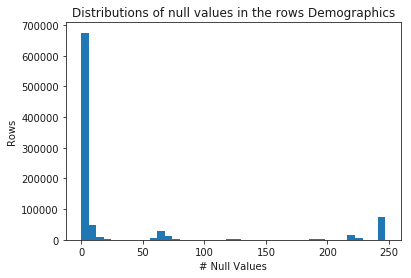

In [1039]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

In [1068]:
# We can see that the large majority of the population has less than 50 null fatures.
# we can remove the datapoints with more than 50 nulls in each row
azdias.dropna(thresh=azdias.shape[1] - 50, inplace=True)

Text(0,0.5,'Rows')

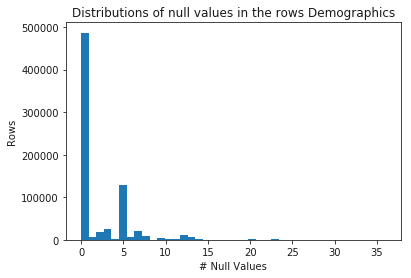

In [1041]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

In [1069]:
azdias.CAMEO_DEUG_2015.value_counts()

8.0    128860
6.0    100692
9.0     99451
4.0     95582
2.0     76611
3.0     76321
7.0     72484
5.0     49713
1.0     34234
Name: CAMEO_DEUG_2015, dtype: int64

In [1070]:
# Saving
azdias = azdias.reset_index()
del azdias['index']
azdias.to_feather('azdias_cols_dropped.feather')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [1071]:
# Let's see how many rows, columns we are left with
azdias.shape

(737288, 288)

### Features Re-encoding
Some categorical features need re-encoding. We will look at the spreadsheet to choose which ones to re-encode.
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling will be necessary for the remaining two variable types: categorical, and 'mixed'.

Are there binary categorical features that need re-encoding?
Are there multi-level categorical features that need re-encoding?


In [1075]:
azdias = pd.read_feather('azdias_cols_dropped.feather', nthreads=2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [1076]:
# Binary categorical features
# OST_WEST_KZ: flag indicating the former GDR/FRG
#azdias['OST_WEST_KZ'].value_counts()

ost_west_dict = {'OST_WEST_KZ': {'W':0, 'O':1}}
azdias.replace(ost_west_dict, inplace=True)

Multi-level categoricals (three or more values) will be one-hot encoded using multiple dummy variables.

In [1077]:
# Multi value features 

categorical_features = np.intersect1d(azdias_info[azdias_info.Type=='Categorical'].Attribute.values, azdias.columns.values)
azdias_info[azdias_info.Attribute.isin(categorical_features)]

,Attribute,Description,Meaning,Value,Type,Notes
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,unknown,-1,Categorical,NaN
131,CJT_GESAMTTYP,customer journey typology,unknown,0,Categorical,NaN
654,FINANZTYP,best descirbing financial type for the person,unknown,-1,Categorical,NaN
697,GEBAEUDETYP,type of building (residential or commercial),unknown,"-1, 0",Categorical,NaN
744,HEALTH_TYP,health typology,unknown,-1,Categorical,NaN
2070,REGIOTYP,neighbourhood,unknown,"-1, 0",Categorical,NaN
2084,RETOURTYP_BK_S,return type,unknown,0,Categorical,NaN
2202,SHOPPER_TYP,shopping typology,unknown,-1,Categorical,NaN
2229,WOHNLAGE,residential-area,unknown,-1,Categorical,NaN
2251,ZABEOTYP,typification of energy consumers,unknown,"-1, 9",Categorical,NaN


In [1078]:
# We drop LP_FAMILIE_GROB and one-hot encode the other categorical feats
azdias = azdias.drop('LP_FAMILIE_GROB', axis=1)

In [1079]:
# One hot encoding
one_hot_encode_cols = np.intersect1d(azdias_info[azdias_info.Type=='Categorical'].Attribute.values, azdias.columns.values)
azdias = pd.get_dummies(azdias, columns=one_hot_encode_cols)

In [1080]:
azdias.shape

(737288, 429)

### Engineer Mixed-Type Features
There are two of features that we marked as "mixed" in the azdias_info dataframe that require special treatment in order to be included in the analysis. 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [704]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

azdias['PRAEGENDE_JUGENDJAHRE'].isnull().sum()

21187

PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [1081]:
# Mainstream feature
mainstream_dict = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1, 13.0:2, 14.0:1, 15.0:2}
azdias['MAINSTREAM'] = np.nan
azdias['MAINSTREAM'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(mainstream_dict)
generation_dict = {1.0:1, 2.0:1, 3.0:2, 4.0:2, 5.0:3, 6.0:3, 7.0:3, 8.0:4, 9.0:4, 10.0:5, 11.0:5, 12.0:5, 13.0:5, 14.0:6, 15.0:6}
azdias['GENERATION'] = np.nan
azdias['GENERATION'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)  

In [1082]:
# Wealth Feature
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
azdias['FAMILY'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan) 

In [1083]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'],axis=1, inplace=True)

In [1084]:
azdias.to_feather('azdias_re-encodeds.feather')

## Feature Transformation

### Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.  In this substep, we will  check the following:

- Before applying the scaler to the data, we need to make sure that we've cleaned the DataFrame of the remaining missing values. This could be as simple as just removing all data points with missing data, thereby losing a significative percentage of the data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 
- We will separate categorical variables from ordinal and numeric ones, as we will use two different strategies for imputing. Then we intersect with the columns that have null values and finally we add the new engineered Mixed-Type Features
- When imputing, the biggest concern is introducing bias into the data, therefore it's advisable to use different strategies depending on the type of the data. We will use most frequent values for binary variable, median for ordinal ones, and categorical variables have been already handled by creating dummy columns. Finally for numeric columns, if they are skewed we will apply a logarithmic tranform, then impute the median.



In [947]:
azdias = pd.read_feather('azdias_re-encodeds.feather')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [875]:
azdias.isnull().sum()[azdias.isnull().sum().values > 0]

ANZ_HAUSHALTE_AKTIV              5650
ANZ_HH_TITEL                     3325
ANZ_PERSONEN                    30383
ARBEIT                           3889
BALLRAUM                          475
CJT_KATALOGNUTZER                4382
CJT_TYP_1                        4382
CJT_TYP_2                        4382
CJT_TYP_3                        4382
CJT_TYP_4                        4382
CJT_TYP_5                        4382
CJT_TYP_6                        4382
D19_BANKEN_ONLINE_QUOTE_12     164072
D19_GESAMT_ONLINE_QUOTE_12     164072
D19_TELKO_ONLINE_QUOTE_12      164072
D19_VERSAND_ONLINE_QUOTE_12    164072
D19_VERSI_ONLINE_QUOTE_12      164072
EWDICHTE                          475
FIRMENDICHTE                        5
HH_DELTA_FLAG                   30383
INNENSTADT                        475
KBA05_AUTOQUOT                      5
KBA05_HERSTTEMP                  3743
KKK                             41019
KOMBIALTER                      18109
KONSUMNAEHE                        47
KONSUMZELLE 

We have a problem with the D19_ that have a very high number of null values. 
Imputing with a median would introduce an unacceptable bias as the second most frequent value is usually in the few thousands.
Therefor we will:
- impute a zero in the D19_.._QUOTE12 variables (equivalent to "no Online-transactions within the last 12 months")


In [951]:
azdias.GENERATION.value_counts()

6.0    207352
4.0    162933
5.0    138551
3.0    109992
2.0     71262
1.0     26011
Name: GENERATION, dtype: int64

In [1085]:
d19_impute_zero = ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12']

In [1086]:
# Now for the other columns we need to know which are numerical, ordinal, categorical. 
#And we shoudn't forget the last 4 column we added
columns_with_nulls = azdias.columns[azdias.isnull().any()]
# The columns we added manually are the last 4
columns_with_nulls.size

54

In [1087]:
cols_to_impute = np.setdiff1d(columns_with_nulls, d19_impute_zero)

In [1088]:
numeric2impute = azdias_info[(azdias_info.Attribute.isin(cols_to_impute)) & (azdias_info.Type =='Numeric')].Attribute.values
categorical2impute = azdias_info[(azdias_info.Attribute.isin(cols_to_impute)) & (azdias_info.Type =='Categorical')].Attribute.values
ordinal2impute = azdias_info[(azdias_info.Attribute.isin(cols_to_impute)) & (azdias_info.Type =='Ordinal')].Attribute.values
binary2impute = azdias_info[(azdias_info.Attribute.isin(cols_to_impute)) & (azdias_info.Type =='Binary')].Attribute.values
binary2impute = np.append(binary2impute, 'MAINSTREAM')
ordinal2impute = np.concatenate((ordinal2impute, ['GENERATION', 'WEALTH', 'FAMILY']))



In [1089]:
# Quickly check if we have everything
numeric2impute.size + binary2impute.size + ordinal2impute.size + len(d19_impute_zero)

54

In [1090]:
# A look at the numerical variables 
azdias.ANZ_HAUSHALTE_AKTIV.skew(), azdias.ANZ_HH_TITEL.skew(), azdias.ANZ_PERSONEN.skew()

(8.720806697343331, 22.366734240379014, 1.9684237732931673)

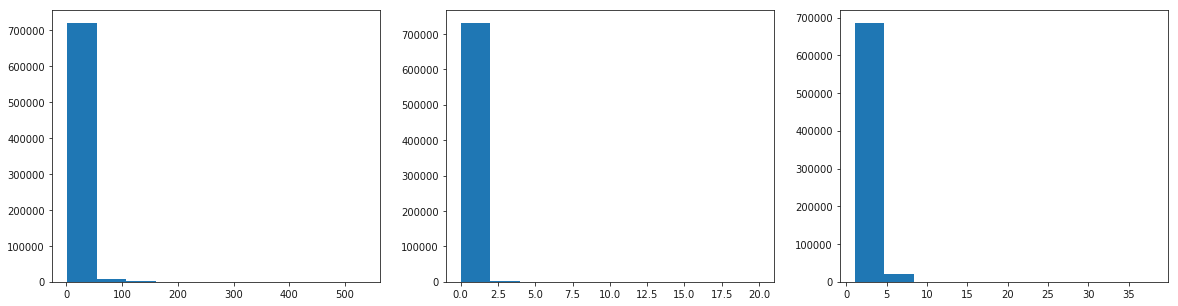

In [1091]:
#We now have a look at the distributions of numerical variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(azdias.ANZ_HAUSHALTE_AKTIV.dropna());
plt.subplot(1, 3, 2)
plt.hist(azdias.ANZ_HH_TITEL.dropna());
plt.subplot(1, 3, 3)
plt.hist(azdias.ANZ_PERSONEN.dropna());
plt.show()

The therendistributiones look all right skewed: when data are very non-normal (and e.g. needs a log-transformation to give approximate normality), then any imputation method assuming normality may not perform so well. Therefore we will log-tranform the numerical features before applying imputation

In [1092]:
numeric2impute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN'],
      dtype=object)

In [1093]:
# Log transform numeric features
#from sklearn.preprocessing import FunctionTransformer
azdias['ANZ_HAUSHALTE_AKTIV'] = azdias['ANZ_HAUSHALTE_AKTIV'].apply(lambda x: np.log1p(1+x) if x != np.nan else x)
azdias['ANZ_HH_TITEL'] = azdias['ANZ_HH_TITEL'].apply(lambda x: np.log1p(1+x) if x != np.nan else x)
azdias['ANZ_PERSONEN'] = azdias['ANZ_PERSONEN'].apply(lambda x: np.log1p(1+x) if x != np.nan else x)


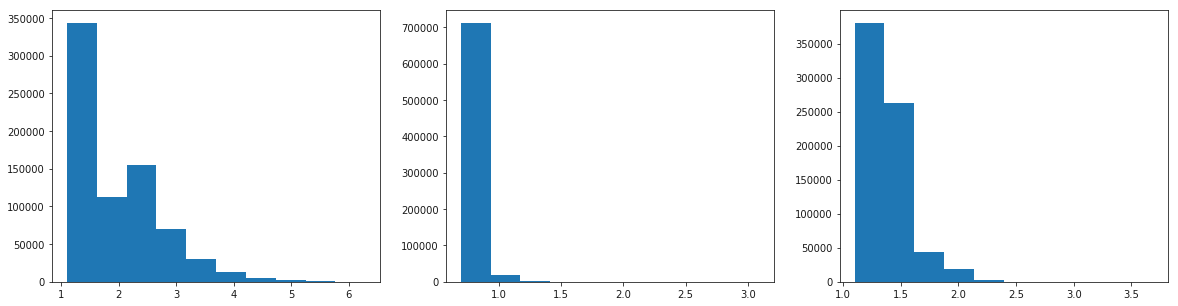

In [1094]:
#We can have a look at the distributions of numerical variables again
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(azdias.ANZ_HAUSHALTE_AKTIV.dropna());
plt.subplot(1, 3, 2)
plt.hist(azdias.ANZ_HH_TITEL.dropna());
plt.subplot(1, 3, 3)
plt.hist(azdias.ANZ_PERSONEN.dropna());
plt.show()

A bit better, but still skewed. So we will use meadian to impute instead of mean.

In [1095]:
# Now we can impute
from sklearn.impute import SimpleImputer
# Ordinal features
imputer_median = SimpleImputer(strategy='median')
azdias[ordinal2impute] = imputer_median.fit_transform(azdias[ordinal2impute])
# Nuneric features
imputer_numeric = SimpleImputer(strategy='median')
azdias[numeric2impute] = imputer_numeric.fit_transform(azdias[numeric2impute])
# Binary features
imputer_binary = SimpleImputer(strategy='most_frequent')
azdias[binary2impute] = imputer_binary.fit_transform(azdias[binary2impute])
# Let's not forget the d19
azdias[d19_impute_zero] = azdias[d19_impute_zero].fillna(0)


In [1096]:
# Now we can apply Standard Scaling to all numerical and ordinal columns
from sklearn.preprocessing import StandardScaler

ordinal_features = np.intersect1d(azdias_info[azdias_info.Type=='Ordinal'].Attribute.values, azdias.columns.values)
ordinal_features = np.concatenate((ordinal_features, ['GENERATION', 'WEALTH', 'FAMILY']))
numeric_features = np.intersect1d(azdias_info[azdias_info.Type=='Numeric'].Attribute.values, azdias.columns.values)

ordinal_features
#l2 = set(ordinal_features).union(numeric_features).union(set(['WEALTH', 'FAMILY']))     

#features_to_scale = sorted(set(ze.columns) & set(l2), key = l1.index)
features_to_scale = np.concatenate((ordinal_features, numeric_features))
scaler=StandardScaler()
azdias[features_to_scale] = scaler.fit_transform(azdias[features_to_scale])

/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [1097]:
azdias.to_feather('azdias_scaled.feather')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA
On the scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [3]:
azdias = pd.read_feather('azdias_scaled.feather', nthreads=2)
from sklearn.decomposition import PCA

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [1100]:
pca = PCA()
pca.fit(azdias)
azdias_pca = pca.transform(azdias)

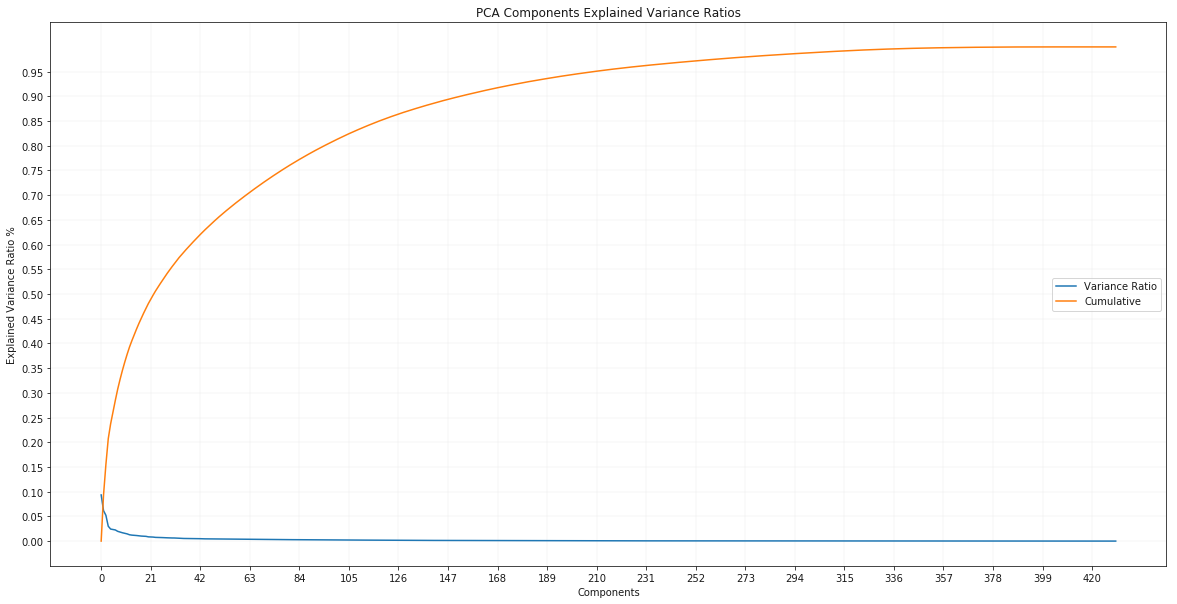

In [1101]:
def show_pca(pca):
    cumulative_ratios=np.zeros(len(pca.explained_variance_ratio_))
    for i in range(len(pca.explained_variance_ratio_)):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
    plt.figure(figsize=(20,10))
    plt.plot(pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step= (len(pca.explained_variance_ratio_) // 20)))
    plt.grid(linewidth=0.1)
    plt.legend(['Variance Ratio', 'Cumulative'], loc='center right')
    
show_pca(pca)

In [1113]:

np.sum(pca.explained_variance_ratio_[:155])

0.9033910682955497

In [7]:
#The pca without parameters returned all the 431 components (same as n. of features)
#The plot shows that over 80% of the variance is explained by the first 95 components, 90% by the first 155 components and after that it increases very slowly
#So we will run it again but this time we want only 155 components
pca = PCA(n_components=155)
pca.fit(azdias)
azdias_pca = pca.transform(azdias)

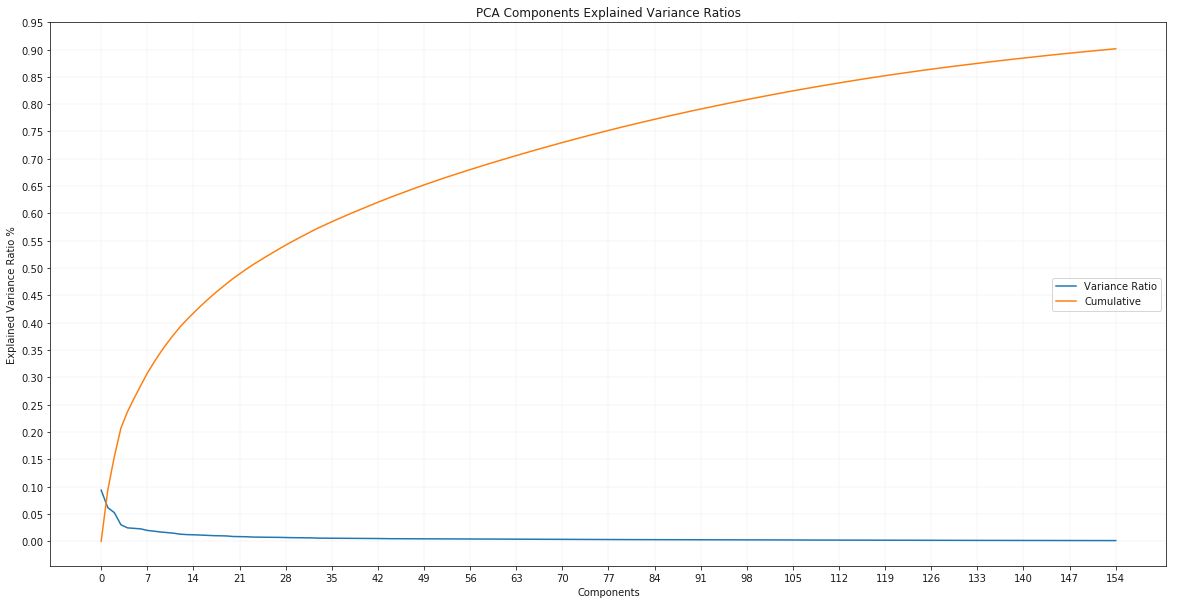

In [1115]:
show_pca(pca)

In [1116]:
def pca_results(full_dataset, pca, component):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (20,10))

    # Plot the feature weights as a function of the components
    features_to_show = components.iloc[component - 1].sort_values(ascending=False)
    features_to_show = features_to_show[np.absolute(features_to_show.values) >= 0.01]
    #components.iloc[component - 1].sort_values(ascending=False).plot(ax = ax, kind = 'bar');
    features_to_show.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(list(features_to_show.keys()), rotation=90)
    ax.set_xlabel("Features")

    # Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    ev = pca.explained_variance_ratio_[component-1]
    
    plt.title("Component {} Explained Variance: {:.2f}%".format(component, ev*100))

    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1).iloc[component - 1].sort_values(ascending=False)
    return features_to_show

PLZ8_ANTG3                    0.1526
KBA13_ANTG3                   0.1516
KBA13_ANTG4                   0.1487
KBA13_BAUMAX                  0.1479
PLZ8_ANTG4                    0.1473
PLZ8_BAUMAX                   0.1462
ANZ_HAUSHALTE_AKTIV           0.1434
WEALTH                        0.1380
HH_EINKOMMEN_SCORE            0.1338
EWDICHTE                      0.1225
ORTSGR_KLS9                   0.1219
FINANZ_HAUSBAUER              0.1052
ARBEIT                        0.1015
PLZ8_ANTG2                    0.1012
KBA13_HALTER_30               0.1007
KBA05_ANTG4                   0.0959
KBA13_HALTER_35               0.0945
KBA05_ANTG3                   0.0910
RELAT_AB                      0.0857
KBA05_BAUMAX                  0.0857
STRUKTURTYP                   0.0848
ANZ_STATISTISCHE_HAUSHALTE    0.0830
CJT_TYP_2                     0.0826
KBA13_ANTG2                   0.0775
KBA13_ALTERHALTER_30          0.0754
FINANZ_SPARER                 0.0731
KBA13_BJ_2000                 0.0640
V

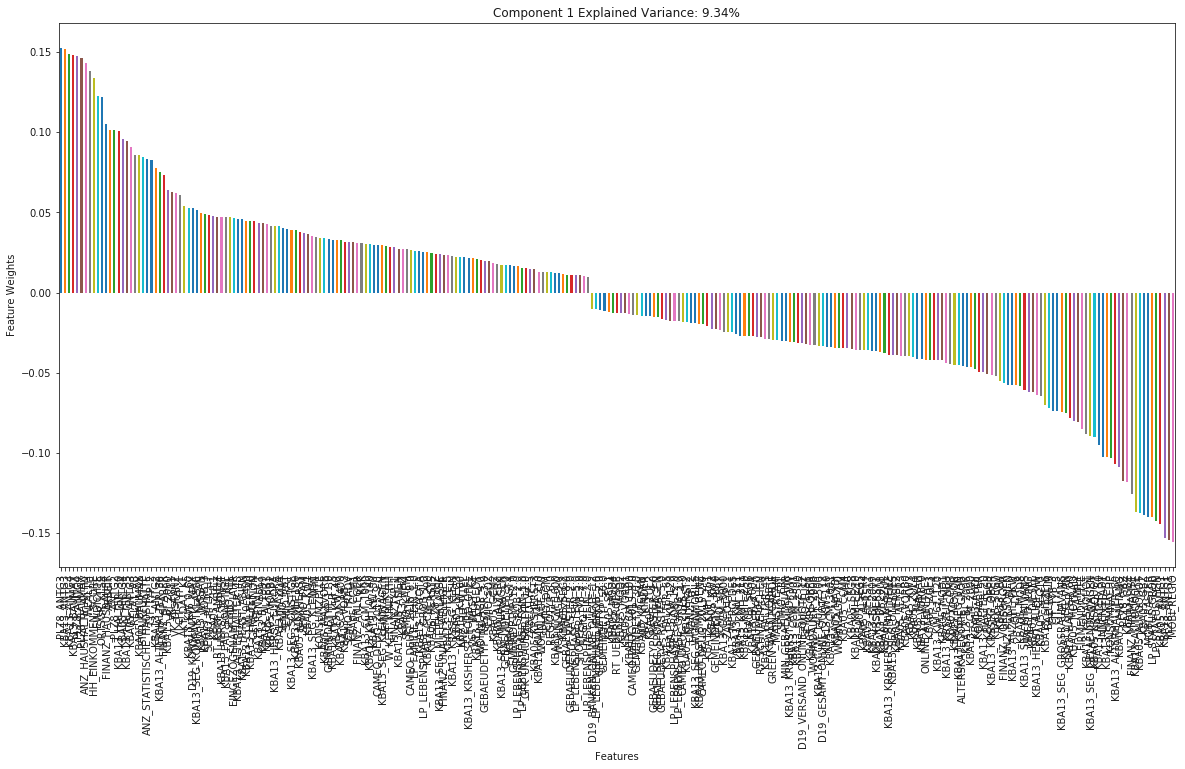

In [1117]:
pca_results(azdias, pca, 1)

# First component
Positive correlations
PLZ8_ANTG3: # of 6-10 family houses in the area
PLZ8_ANTG4 # of +10 families in the area  
KBA13_BAUMAX : Building type
ANZ_HAUSHALTE_AKTIV # of households in the building
WEALTH: here small value means wealthy households, high values poorer households

Neg Correlations:
MOBI_REGIO: mobility patterns, where a higher value means low mobility, more stability
PLZ_ANTG1: share of small families
LP_STATUS_FEIN/GROB: Social status

So this component is positively correlated to share of bigger families (more densily populated, less wealthy) in the area and building and negatively correlated with social status and stability (younger, not wealthy thend to rent and change often) 

KBA13_HERST_BMW_BENZ           0.1890
KBA13_SEG_OBEREMITTELKLASSE    0.1621
KBA13_MERCEDES                 0.1608
KBA13_BMW                      0.1582
KBA13_SITZE_4                  0.1480
KBA13_SEG_SPORTWAGEN           0.1443
KBA13_KMH_211                  0.1332
KBA05_HERST1                   0.1322
KBA13_KMH_250                  0.1309
KBA13_KW_121                   0.1297
KBA13_SEG_OBERKLASSE           0.1271
KBA13_CCM_2501                 0.1231
KBA05_KW3                      0.1215
KBA13_CCM_3000                 0.1145
KBA05_MOTOR                    0.1135
KBA13_KRSHERST_BMW_BENZ        0.1130
KBA13_CCM_3001                 0.1093
KBA05_MOD1                     0.1076
KBA05_CCM4                     0.1074
EWDICHTE                       0.1053
KBA13_HALTER_65                0.0994
KBA05_SEG5                     0.0980
STRUKTURTYP                    0.0958
ORTSGR_KLS9                    0.0930
KBA13_CCM_2500                 0.0912
KBA05_CCM3                     0.0854
KBA05_SEG8  

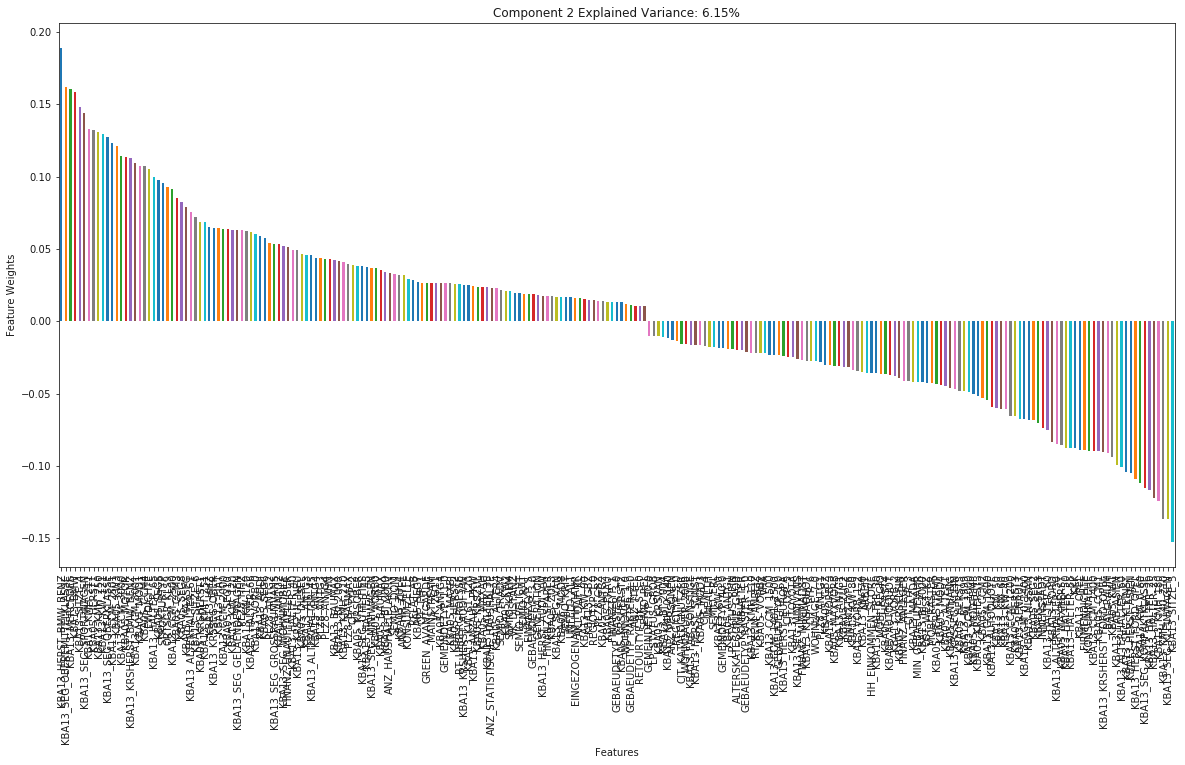

In [1119]:
# Second component
pca_results(azdias, pca, 2)

### Second Component
Positive Corr:
KBA13_HERST_BMW_BENZ           0.1890: Share of BMW & Mercedes in the area
KBA13_SEG_OBEREMITTELKLASSE    0.1621: share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA13_MERCEDES                 0.1608: share of Mercedes in the area
KBA13_BMW : share of BMW in the area
KBA13_SEG_SPORTWAGEN: Share of sportcars
    
Negatice corr:
KBA13_SEG_KLEINWAGEN:    Share of small cars
KBA13_KMH_140_210 : Share of cars with max speed between 140 and 210
KBA13_HALTER_25, KBA13_HALTER_20: Young drivers

Looks like this component is positively correlated with uppr-middle class indicators like owning a BMW, Merc or Sportcar, mature drivers



KOMBIALTER                     0.2215
FINANZ_VORSORGER               0.1991
CJT_TYP_5                      0.1925
ALTERSKATEGORIE_GROB           0.1907
CJT_TYP_4                      0.1832
CJT_TYP_3                      0.1780
CJT_TYP_6                      0.1757
SEMIO_LUST                     0.1445
CJT_KATALOGNUTZER              0.1397
SEMIO_ERL                      0.1294
FINANZ_MINIMALIST              0.1078
W_KEIT_KIND_HH                 0.1062
ZABEOTYP_3                     0.0745
RETOURTYP_BK_S_5.0             0.0655
WOHNDAUER_2008                 0.0614
FINANZ_HAUSBAUER               0.0592
KBA05_ALTER4                   0.0547
KBA13_ANTG3                    0.0541
EWDICHTE                       0.0530
PLZ8_ANTG3                     0.0525
ORTSGR_KLS9                    0.0508
KBA13_ANTG4                    0.0506
PLZ8_ANTG4                     0.0484
KBA05_MAXAH                    0.0478
ARBEIT                         0.0473
KBA05_VORB0                    0.0472
KBA13_BAUMAX

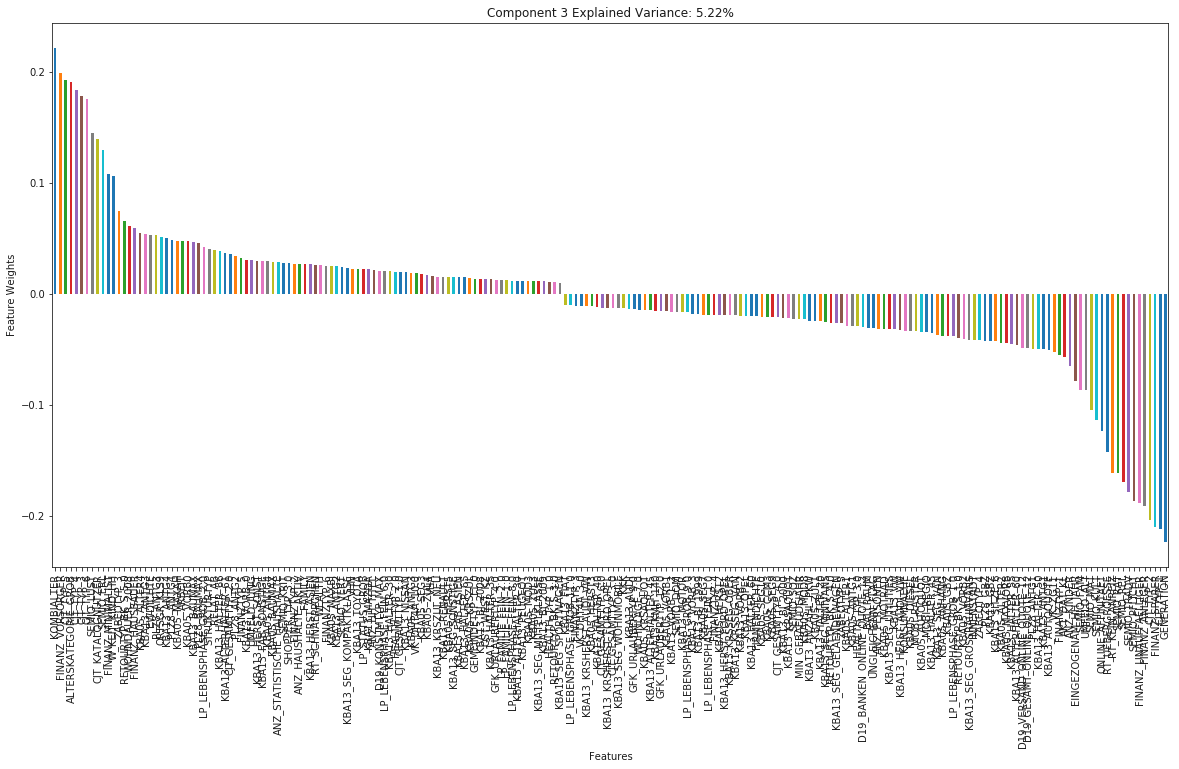

In [1120]:
pca_results(azdias, pca, 3)

### Third Component

Positively Corr:
KOMBIALTER                     0.2217
FINANZ_VORSORGER               0.1992: Financially: be preparer
CJT_TYP_5                      0.1927  Customer-Journey-Typology relating to the preferred information and buying channels of consumers
                                       Advertising- and Cross-Channel-Enthusiast
ALTERSKATEGORIE_GROB           0.1909 Age classification: higher -> older
CJT_TYP_4                      0.1834 advertisinginterested Online-shopper
CJT_TYP_3                      0.1782  advertisinginterested Store-shopper
CJT_TYP_6 Advertising-Enthusiast with restricted Cross-Channel-Behaviour 

Neg Corr
SEMIO_PFLICHT                 -0.1870 Traditionally minded (higher == less affinity)
FINANZ_UNAUFFAELLIGER         -0.1888 Financial Typology: unremarkable (higher = low)
FINANZ_ANLEGER                -0.1915 Investor? (high value = low likelihood)
CJT_TYP_2                     -0.2043 Advertising- and Consumptiontraditionalist
FINANZ_SPARER                 -0.2101 money saver (low value = very high)
CJT_TYP_1                     -0.2119 Advertising- and Consumptionminimalist
GENERATION (higher values == younger)

So this component is indicating the Customer Journey, positively correlated with younger and more 
multi-channel enthusiast people and negatively correlated with traditionalist, older people


KBA13_KW_61_120            0.1823
KBA13_KMH_210              0.1686
KBA13_VORB_0               0.1524
KBA13_CCM_1401_2500        0.1517
KBA13_SITZE_5              0.1443
KBA13_HERST_ASIEN          0.1138
KBA13_BJ_2006              0.1103
KBA05_VORB0                0.1091
KBA13_HALTER_25            0.1079
KBA13_KRSZUL_NEU           0.1044
KBA13_ALTERHALTER_30       0.1011
ARBEIT                     0.1006
KBA05_MAXBJ                0.1004
KBA13_HERST_SONST          0.0960
KBA13_FAB_SONSTIGE         0.0960
KBA13_SEG_MITTELKLASSE     0.0920
KBA13_BJ_2008              0.0910
KBA13_KW_110               0.0853
KBA13_BJ_2009              0.0844
KBA13_CCM_2000             0.0841
KBA13_FAB_ASIEN            0.0835
KBA13_HALTER_30            0.0822
KBA13_SEG_KOMPAKTKLASSE    0.0819
KBA05_HERST5               0.0807
KBA13_TOYOTA               0.0792
KBA05_ZUL4                 0.0767
KBA13_MAZDA                0.0729
KBA13_KW_90                0.0725
KBA05_KRSZUL               0.0719
KBA13_KRSHERST

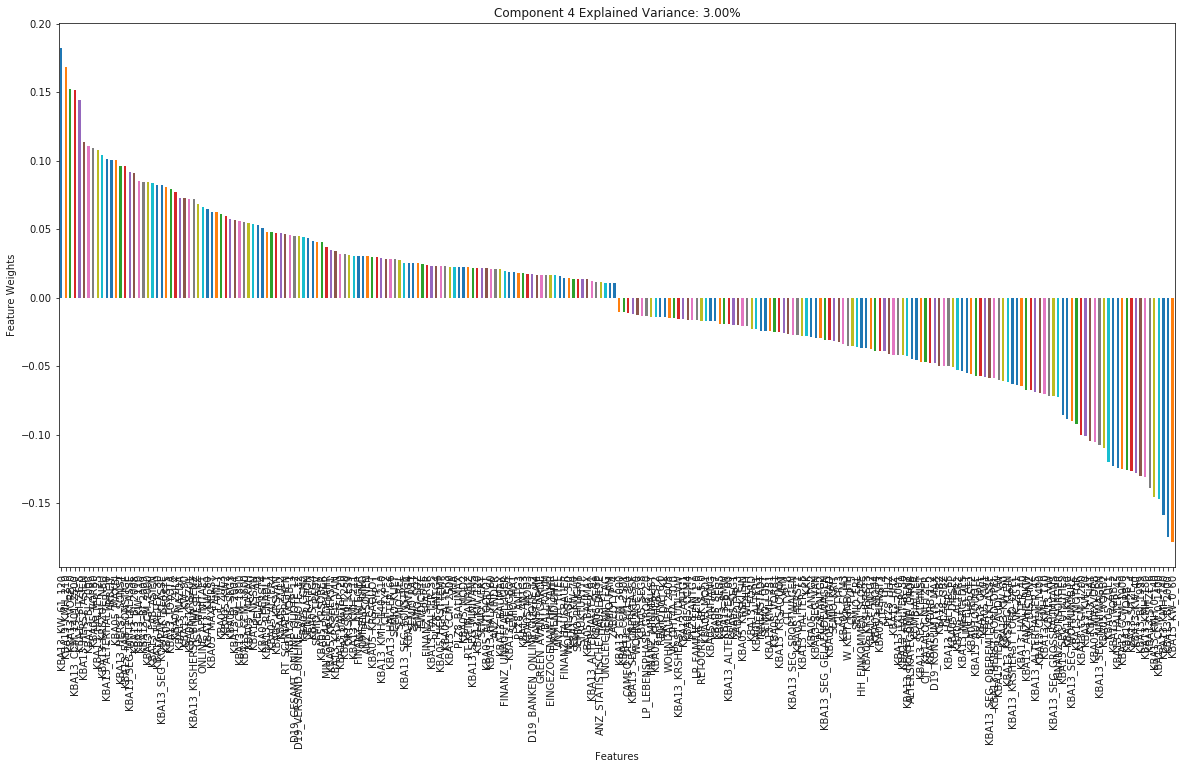

In [1121]:
pca_results(azdias, pca, 4)

Pos
KBA13_KW_61_120            0.1824 share of cars with an engine power between 61 and 120 KW - PLZ8
KBA13_KMH_210              0.1687 share of cars with an engine powermore than 210 - PLZ8
KBA13_VORB_0               0.1524 share of cars with no preowner - PLZ8
KBA13_CCM_1401_2500        0.1518 share of cars with engine size between 1400cc and 2500c
KBA13_SITZE_5 share of cars with 5 seats

Neg:
 KBA13_SITZE_6             -0.1393 share of cars with more than 5 seats
KBA13_KMH_0_140           -0.1455 share of cars with max speed between 0 and 140 kmh
KBA13_CCM_0_1400          -0.1469 share of cars with less than 1400ccm within the PLZ8
KBA13_KMH_140             -0.1590  share of cars with max speed  140 kmh
KBA13_BJ_2000             -0.1746 share of cars built between 2000 and 2003
KBA13_KW_0_60  

Seems posivitely correlated to more powerful, bigger and new cars and negatively correlated with older cars with less power


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In this step, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, we compute the average difference from each point to its assigned cluster's center.
- We perform the above two steps for a number of different cluster counts.
- We then select a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. We obtain the cluster assignments for the general demographics data.

I am using these functions instead of model.score to calculate the average distance of the points in the cluster 
from the centroid. I play with it first in two dimensions and then generalize to n-dimensions

Thanks to alphaleonis and Shay.G at https://stackoverflow.com/questions/40828929/sklearn-mean-distance-from-centroid-of-each-cluster for some of the code

uster import KMeans 

# Distance in two dimensions
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)


# Distance in n-dimensions
def k_mean_distance_n(data, centroid, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.linalg.norm(x - centroid) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)

In [15]:
from sklearn.cluster import MiniBatchKMeans 

# Distance in two dimensions
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)


# Distance in n-dimensions
def k_mean_distance_n(data, centroid, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.linalg.norm(x - centroid) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)

In [21]:
# We set the max number of clusters to 20
# This will take a while
    
# compute the average within-cluster distances.
def k_means_score(data, n_clusters):
    # Run k-means
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000)
    model = kmeans.fit(data)
    labels = model.predict(data)
    centroids = model.cluster_centers_
    
    total_distance = []
    for i, c in enumerate(centroids):
        # Function from above
        mean_distance = k_mean_distance_n(data, c, i, labels)
        total_distance.append(mean_distance)
    return(np.mean(total_distance))
  
scores = []
clusters = list(range(1,30))

import progressbar
cnter = 0
bar = progressbar.ProgressBar(maxval=len(clusters)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for n_clusters in clusters:
    scores.append(k_means_score(azdias_pca, n_clusters))
    cnter+=1 
    bar.update(cnter)


bar.finish()    
print(scores)

[========================================================================] 100%


[15.691451286609961, 15.107632525807912, 14.919652883207215, 14.665718695439395, 14.652557857206943, 14.496033350821696, 14.415248665953603, 14.323185845280658, 14.330160042186504, 14.202259826797137, 14.213848395253137, 14.185200596839842, 14.155014929595437, 14.186851766373522, 14.039265027141568, 13.97092744612014, 14.000909149435747, 14.047107433016754, 13.992600690012585, 13.966171226486988, 13.919500026553056, 13.864502775313309, 13.829123458008002, 13.84919538138866, 13.896523126363727, 13.801092320213694, 13.932030494885558, 13.81917156019763, 13.783715994156061]


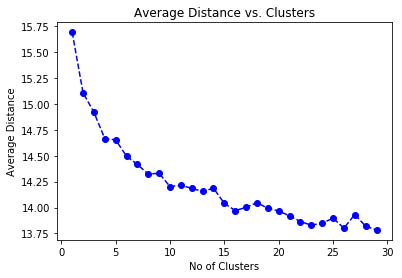

In [22]:
# We will use the elbow method to find the ideal number of clusters
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('No of Clusters');
plt.ylabel('Average Distance');
plt.title('Average Distance vs. Clusters');


Running MiniBatchKMeans instead of KMeans makes the graph a bit bumpier as the average distance does not always decreases with increasing n. of clusters. However, the general trend is the same. 
The graph above shows an elbow at 16 clusters and after 20 the average distance  keeps on decreasing at much lower pace.

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=16)
kmeans_model = kmeans.fit(azdias_pca)
pop_labels = kmeans_model.predict(azdias_pca)
pop_centroids = kmeans_model.cluster_centers_

### Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, we can see how the customer data maps on to those clusters. We will use the fits from the general population to clean, transform, and cluster the customer data. Finally we  will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which i
ncludes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')